# 8장 대표적 비지도 학습법 Autoencoder

비지도 학습은 X만 있는 상태에서 학습하는 것이다. 이러한 비지도 학습 중 가장 널리 쓰이는 신경망으로 **오토인코더**가 있다.

## 8.1 오토인코더 개념

오토인코더는 가운데 계층의 노드 수가 입력값보다 적은 것이 독특한 점이다. 이런 구조로 인해 입력 데이터를 압축하는 효과를 얻게 되고, 또 이 과정이 노이즈 제거에 매우 효과적이라고 알려져 있다.

오토인코더의 핵심은 입력층으로 들어온 데이터를 인코더를 통해 은닉층으로 내보니고, 은닉층의 데이터를 디코더를 통해 출력층으로 내보낸 뒤, 만들어진 출력값을 입력값과 비슷해지도록 만드는 가중치를 찾아내는 것이다.

오토인코더는 변이형 오토인코더, 잡음제거 오토인코더 등 다양한 방식이 있지만, 여기서는 아주 기본적인 형태를 구현하면서 개념을 이해해보도록 하자.

## 8.2 오토인코더 구현하기

1. 라이브러리 임포트

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


2. 하이퍼파라미터로 사용할 옵션들을 미리 빼내어 코드를 구조화

In [2]:
learning_rate = 0.01
training_epoch = 20
batch_size = 100
n_hidden = 256
n_input = 28 * 28

n_hidden은 은닉층의 뉴런 개수를 뜻한다.

3. 신경망 모델ㅇ르 구성한다. 먼저 X의 플레이스 홀더 값을 설정한다. 이 모델은 비지도 학습이므로 Y값이 없다.

In [4]:
X = tf.placeholder(tf.float32, [None, n_input])

4. 오토인코더의 핵심 모델은 인코더와 디코더를 만드는 것이다. 인코더와 디코더를 만드는 방식에 따라 다양한 오토인코더를 만들 수 있다. 아주 간단한 인코더와 디코더를 만들어보자.

In [5]:
W_encode = tf.Variable(tf.random_normal([n_input, n_hidden]))
b_encode = tf.Variable(tf.random_normal([n_hidden]))

encoder = tf.nn.sigmoid(
                tf.add(tf.matmul(X, W_encode), b_encode))

맨 처음에는 n\_hidden 개의 뉴런을 가진 은닉층을 만든다. 그리고 가중치와 편향 변수를 원하는 뉴런의 개수만큼 설정하고, 그 변수들을 입력값과 곱하고 더한 뒤, 활성화함수인 sigmoid 함수를 적용한다.

중요한 것은 n\_input의 값보다 n\_hidden의 값이 더 적다는 것이다. (물론 은닉층이 더 큰 오토인코더 모델도 있다) 이렇게 하면 입력값을 압축하고 노이즈를 제거하면서 입력값의 특징을 찾아내게 된다.

5. 디코더 차례이다.

In [6]:
W_decode = tf.Variable(tf.random_normal([n_hidden, n_input]))
b_decode = tf.Variable(tf.random_normal([n_input]))

decoder = tf.nn.sigmoid(
            tf.add(tf.matmul(encoder, W_decode), b_decode))

디코더도 인코더와 같은 구성이지만, 입력값을 은닉층의 크기로, 출력값을 입력층의 크기로 만들었다. 이렇게 하면 최종 모델의 구성은 다음과 같아진다.

입력층(784) $\rightarrow$ 은닉층(256) $\rightarrow$ 출력층(784)

6. 가중치들을 최적화하기 위한 손실 함수를 만들어보자. 오코인코더의 기본 목적은 출력값을 입력값과 가장 비슷하게 만드는 것이다. 그렇게 하면 압축된 은닉층의 뉴런들을 통해 입력값의 특징을 알아낼 수 있다. 따라서 다음과 같이 입력값인 X를 평가하기 위해 실측값으로 사용하고, 디코더가 내보낸 결괏값과의 차이를 손실값으로 설정한다. 그리고 이 값의 차이는 거리 함수로 구하도록 한다.

In [7]:
cost = tf.reduce_mean(tf.pow(X-decoder, 2))

7. 마지막으로 RMSPropOptimizer 함수를 이용한 최적화 함수를 설정한다.

In [9]:
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

8. 학습을 진행하자

In [11]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

total_batch = int(mnist.train.num_examples / batch_size)

for epoch in range(training_epoch):
    total_cost = 0
        
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        
        total_cost += cost_val
        
    print ('Epoch:', '%04d' % (epoch + 1), 'Avg. cost = ', '{:.3f}'.format(total_cost / total_batch))
    
print ('최적화 완료!')

Epoch: 0001 Avg. cost =  0.204
Epoch: 0002 Avg. cost =  0.063
Epoch: 0003 Avg. cost =  0.047
Epoch: 0004 Avg. cost =  0.042
Epoch: 0005 Avg. cost =  0.038
Epoch: 0006 Avg. cost =  0.035
Epoch: 0007 Avg. cost =  0.032
Epoch: 0008 Avg. cost =  0.031
Epoch: 0009 Avg. cost =  0.030
Epoch: 0010 Avg. cost =  0.030
Epoch: 0011 Avg. cost =  0.029
Epoch: 0012 Avg. cost =  0.029
Epoch: 0013 Avg. cost =  0.029
Epoch: 0014 Avg. cost =  0.028
Epoch: 0015 Avg. cost =  0.028
Epoch: 0016 Avg. cost =  0.027
Epoch: 0017 Avg. cost =  0.026
Epoch: 0018 Avg. cost =  0.026
Epoch: 0019 Avg. cost =  0.026
Epoch: 0020 Avg. cost =  0.025
최적화 완료!


9. 결괏값을 정확도가 아닌, 디코더로 생성해낸 결과를 직관적인 방법으로 확인해 보자. 결과를 확인하는 방법은 다양하지만, 여기서는 간단하게 matplotlib을 이용해 이미지로 출력해 보자.

In [12]:
sample_size = 10

samples = sess.run(decoder,
                   feed_dict={X: mnist.test.images[:sample_size]})

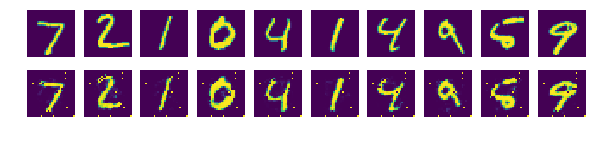

In [18]:
fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    ax[1][i].imshow(np.reshape(samples[i], (28, 28)))
    
plt.show()

## 전체 코드

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 Avg. cost =  0.197
Epoch: 0002 Avg. cost =  0.056
Epoch: 0003 Avg. cost =  0.041
Epoch: 0004 Avg. cost =  0.036
Epoch: 0005 Avg. cost =  0.032
Epoch: 0006 Avg. cost =  0.030
Epoch: 0007 Avg. cost =  0.029
Epoch: 0008 Avg. cost =  0.028
Epoch: 0009 Avg. cost =  0.027
Epoch: 0010 Avg. cost =  0.027
Epoch: 0011 Avg. cost =  0.027
Epoch: 0012 Avg. cost =  0.026
Epoch: 0013 Avg. cost =  0.024
Epoch: 0014 Avg. cost =  0.024
Epoch: 0015 Avg. cost =  0.024
Epoch: 0016 Avg. cost =  0.024
Epoch: 0017 Avg. cost =  0.023
Epoch: 0018 Avg. cost =  0.022
Epoch: 0019 Avg. cost =  0.022
Epoch: 0020 Avg. cost =  0.022
최적화 완료!


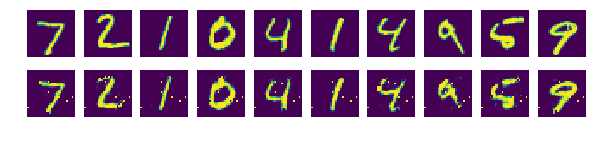

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot = True)

###########
# 옵션 설정 #
##########

learning_rate = 0.01
training_epoch = 20
batch_size = 100
n_hidden = 256
n_input = 28 * 28

################
# 신경망 모델 구성 #
################

X = tf.placeholder(tf.float32, [None, n_input])

W_encode = tf.Variable(tf.random_normal([n_input, n_hidden]))
b_encode = tf.Variable(tf.random_normal([n_hidden]))
encoder = tf.nn.sigmoid(
                tf.add(tf.matmul(X, W_encode), b_encode))

W_decode = tf.Variable(tf.random_normal([n_hidden, n_input]))
b_decode = tf.Variable(tf.random_normal([n_input]))
decoder = tf.nn.sigmoid(
                tf.add(tf.matmul(encoder, W_decode), b_decode))

cost = tf.reduce_mean(tf.pow(X - decoder, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

################
# 신경망 모델 학습 #
################

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

total_batch = int(mnist.train.num_examples / batch_size)

for epoch in range(training_epoch):
    total_cost = 0
        
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        
        total_cost += cost_val
        
    print ('Epoch:', '%04d' % (epoch + 1), 'Avg. cost = ', '{:.3f}'.format(total_cost / total_batch))
    
print ('최적화 완료!')

###########
# 결과 확인 #
##########

sample_size = 10

samples = sess.run(decoder,
                   feed_dict={X: mnist.test.images[:sample_size]})

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    ax[1][i].imshow(np.reshape(samples[i], (28, 28)))
    
plt.show()